# Imports

In [2]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, Model,
                   ModelResult, MedianEpsilon)
from pyabc.transition import MultivariateNormalTransition
from pyabc.visualization import plot_kde_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'
import os
import tempfile
import math
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO

from pyabc_custom import MyokitSimulation
from prangle_distance import PrangleDistance,PranglePopulationSize,PrangleEpsilon

# Get experimental measurements

In [3]:
myokit_python = ('/tmp/chouston/miniconda3/envs' +
                 '/ion_channel_ABC/bin/python')
args = [myokit_python, 'get_measurements.py']
args.append('ical')
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=False)
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']

# Set limits and generate uniform initial priors

In [4]:
limits = dict(g_CaL=(0, 0.001),
              p1=(-50, 50),
              p2=(0, 100),
              p3=(-100, 100),
              p4=(-100, 100),
              p5=(-100, 100),
              p6=(-100, 100),
              p7=(0, 1000),
              p8=(0, 1000),
              q1=(0, 100),
              q2=(0, 100),
              q3=(0, 10000),
              q4=(0, 100),
              q5=(0, 1000),
              q6=(0, 1000),
              q7=(0, 100),
              q8=(0, 100),
              q9=(-1000,1000))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Define ABC parameters and initialise database

In [5]:
myokit_model = MyokitSimulation('ical')
#myokit_model.sample(prior.rvs())

In [11]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ical.db"))

In [12]:
abc = ABCSMC(models=myokit_model,
             parameter_priors=prior,
             distance_function=PrangleDistance(
                 exp_map=exp,
                 alpha=0.5,
                 delta=0.5,
                 adapt=False),
             population_size=PranglePopulationSize(
                 500, alpha=0.5,
                 adapt=True,
                 mean_cv=0.5,
                 min_population_size=200,
                 max_population_size=5000),
             eps=PrangleEpsilon(100, alpha=0.5))

In [13]:
abc_id = abc.new(db_path, obs)

INFO:Epsilon:initial epsilon is 100
INFO:History:Start <ABCSMC(id=1, start_time=2018-06-28 19:59:13.127698, end_time=None)>


In [21]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10)

INFO:ABC:t:30 M eps:[100.          34.81847516  14.13698132   9.85091795   9.10290762
   7.55591522   6.25927599   5.33677068   4.79428829   4.37521381
   4.05793047   3.83618013   3.69601488   3.54732765   3.37702613
   3.15431806   2.93193536   2.66810745   2.44204334   2.23600916
   2.06393673   1.91548081   1.77936383   1.67942059   1.60898033
   1.55399382   1.49866631   1.46136112   1.42439929   1.39296955
   1.37055722]
INFO:Adaptation:Change nr particles 5000 -> 5000
INFO:ABC:t:30 N eps:1.355489227694105
INFO:ABC:N population size: 5000
INFO:ABC:t:31 M eps:[100.          34.81847516  14.13698132   9.85091795   9.10290762
   7.55591522   6.25927599   5.33677068   4.79428829   4.37521381
   4.05793047   3.83618013   3.69601488   3.54732765   3.37702613
   3.15431806   2.93193536   2.66810745   2.44204334   2.23600916
   2.06393673   1.91548081   1.77936383   1.67942059   1.60898033
   1.55399382   1.49866631   1.46136112   1.42439929   1.39296955
   1.37055722   1.35548923]
INFO:

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/pyabc-0.8.21-py3.6.egg/pyabc/sampler/multicore_evaluation_parallel.py", line 24, in work
    new_sim = simulate_one()
  File "/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/pyabc-0.8.21-py3.6.egg/pyabc/smc.py", line 608, in simulate_one
    par = self._generate_valid_proposal(t, m, p)
  File "/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  Fil

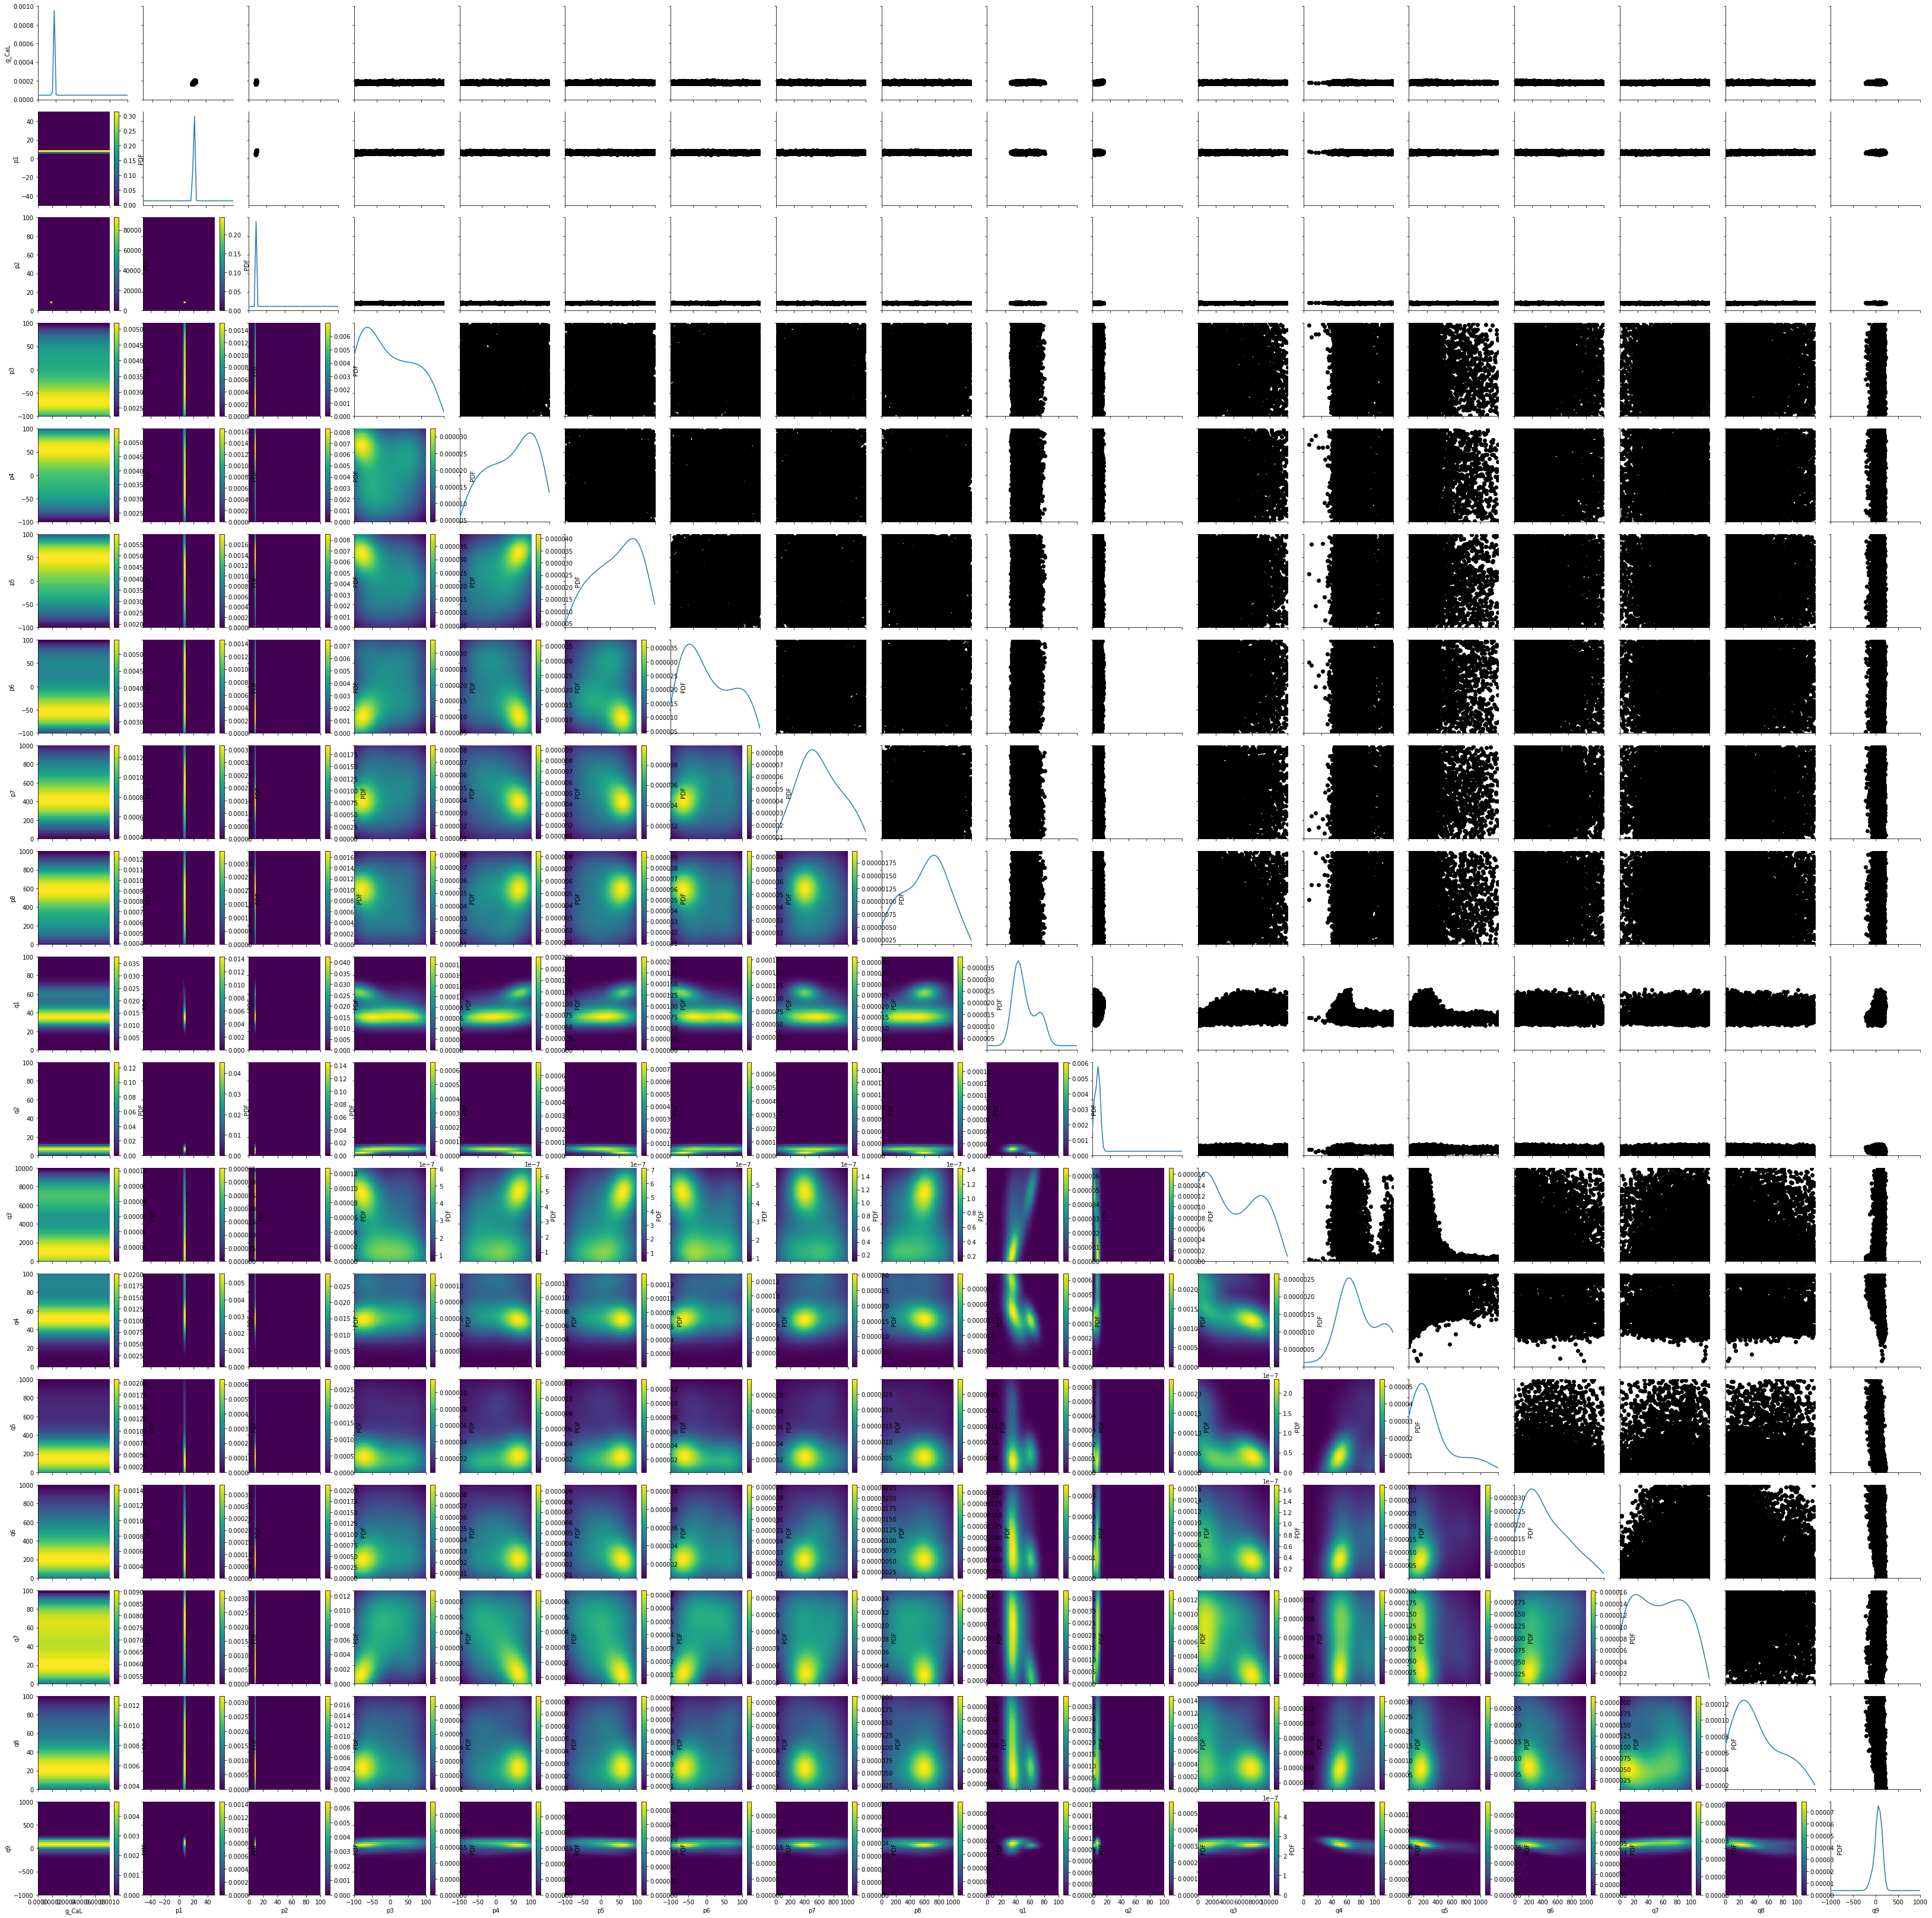

In [23]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

In [6]:
db_path = 'sqlite:///pyabc-runs/hl-1_ical.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-06-28 19:59:13.127698, end_time=2018-06-29 04:16:38.016528)>]

In [7]:
history.id = 1

/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


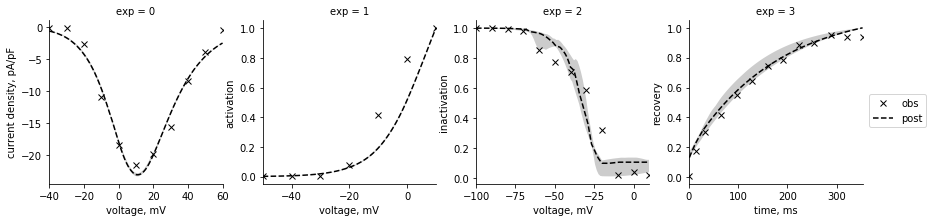

In [8]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'ical', n_samples=10, obs=measurements, original=False)
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
plt.savefig('ical_results.pdf', format='pdf', dpi=1000)

In [9]:
df, w = history.get_distribution(m=0)
df['wt'] = w
print("Mean")
for key in limits.keys():
    print(key, ":", sum(df[key] * df.wt))
print("Min")
for key in limits.keys():
    print(key, ":", min(df[key]))
print("Max")
for key in limits.keys():
    print(key, ":", max(df[key]))

Mean
g_CaL : 0.000181039588035964
p1 : 6.420735038802792
p2 : 8.216327959913095
p3 : -17.020955545798977
p4 : 9.152628064596286
p5 : 10.145473418779948
p6 : -8.523011497610476
p7 : 490.30027633410117
p8 : 484.65473984556985
q1 : 41.955741736879574
q2 : 5.449975871374744
q3 : 3897.7313404033907
q4 : 62.80080009415244
q5 : 249.4039985823946
q6 : 362.1061939466627
q7 : 45.832173659965164
q8 : 39.25710669988645
q9 : 59.706146592575195
Min
g_CaL : 0.00016300198175581452
p1 : 3.9477916554655996
p2 : 7.470257646861133
p3 : -99.97320061085003
p4 : -99.92151024437496
p5 : -99.98615183098693
p6 : -99.90314072924592
p7 : 0.05071080047790133
p8 : 0.13288226563608418
q1 : 26.135388707581207
q2 : 0.015025765658222667
q3 : 0.4727996187622807
q4 : 6.457567266695429
q5 : 0.03063447893822513
q6 : 0.1727011849392568
q7 : 0.17869935918531255
q8 : 0.026171731249640118
q9 : -222.7003508323198
Max
g_CaL : 0.00020650622986699975
p1 : 8.691899177157524
p2 : 9.12858794290225
p3 : 99.98606291590805
p4 : 99.99869

run
0     AxesSubplot(0.125,0.125;0.775x0.755)
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

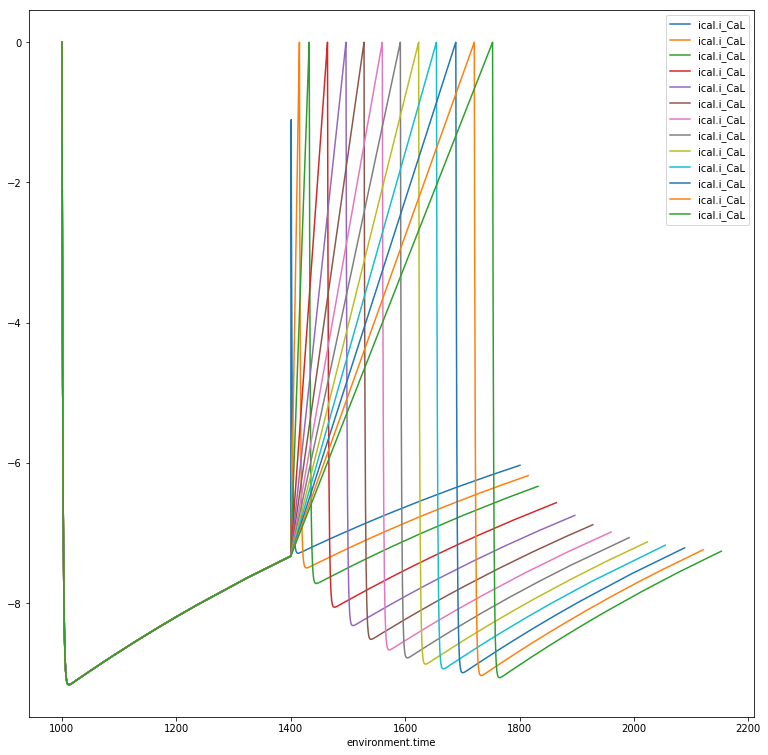

In [14]:
from pyabc_custom import simulate
out = simulate('ical', experiment=3, logvars=['environment.time', 'ical.i_CaL'])
fig,ax = plt.subplots(figsize=(13,13))
out.groupby('run').plot(x='environment.time', y='ical.i_CaL',ax=ax)